Enhanced ResultLogger initialized - now accumulates all results


C:\Users\Yung\AppData\Local\Temp\ipykernel_8044\1056229724.py:137: RuntimeWarning: invalid value encountered in scalar divide
  'score_percentage': lambda x: (np.std(x) / np.mean(x)) * 100,
C:\Users\Yung\AppData\Local\Temp\ipykernel_8044\1056229724.py:172: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_stats = df.groupby('member').apply(
C:\Users\Yung\AppData\Local\Temp\ipykernel_8044\1056229724.py:242: RuntimeWarning: invalid value encountered in scalar divide
  consistency_score = 100 - ((member_data['score_percentage'].std() / avg_score) * 100)


Analysis saved as 'comprehensive_analysis_20250830_003950.png'


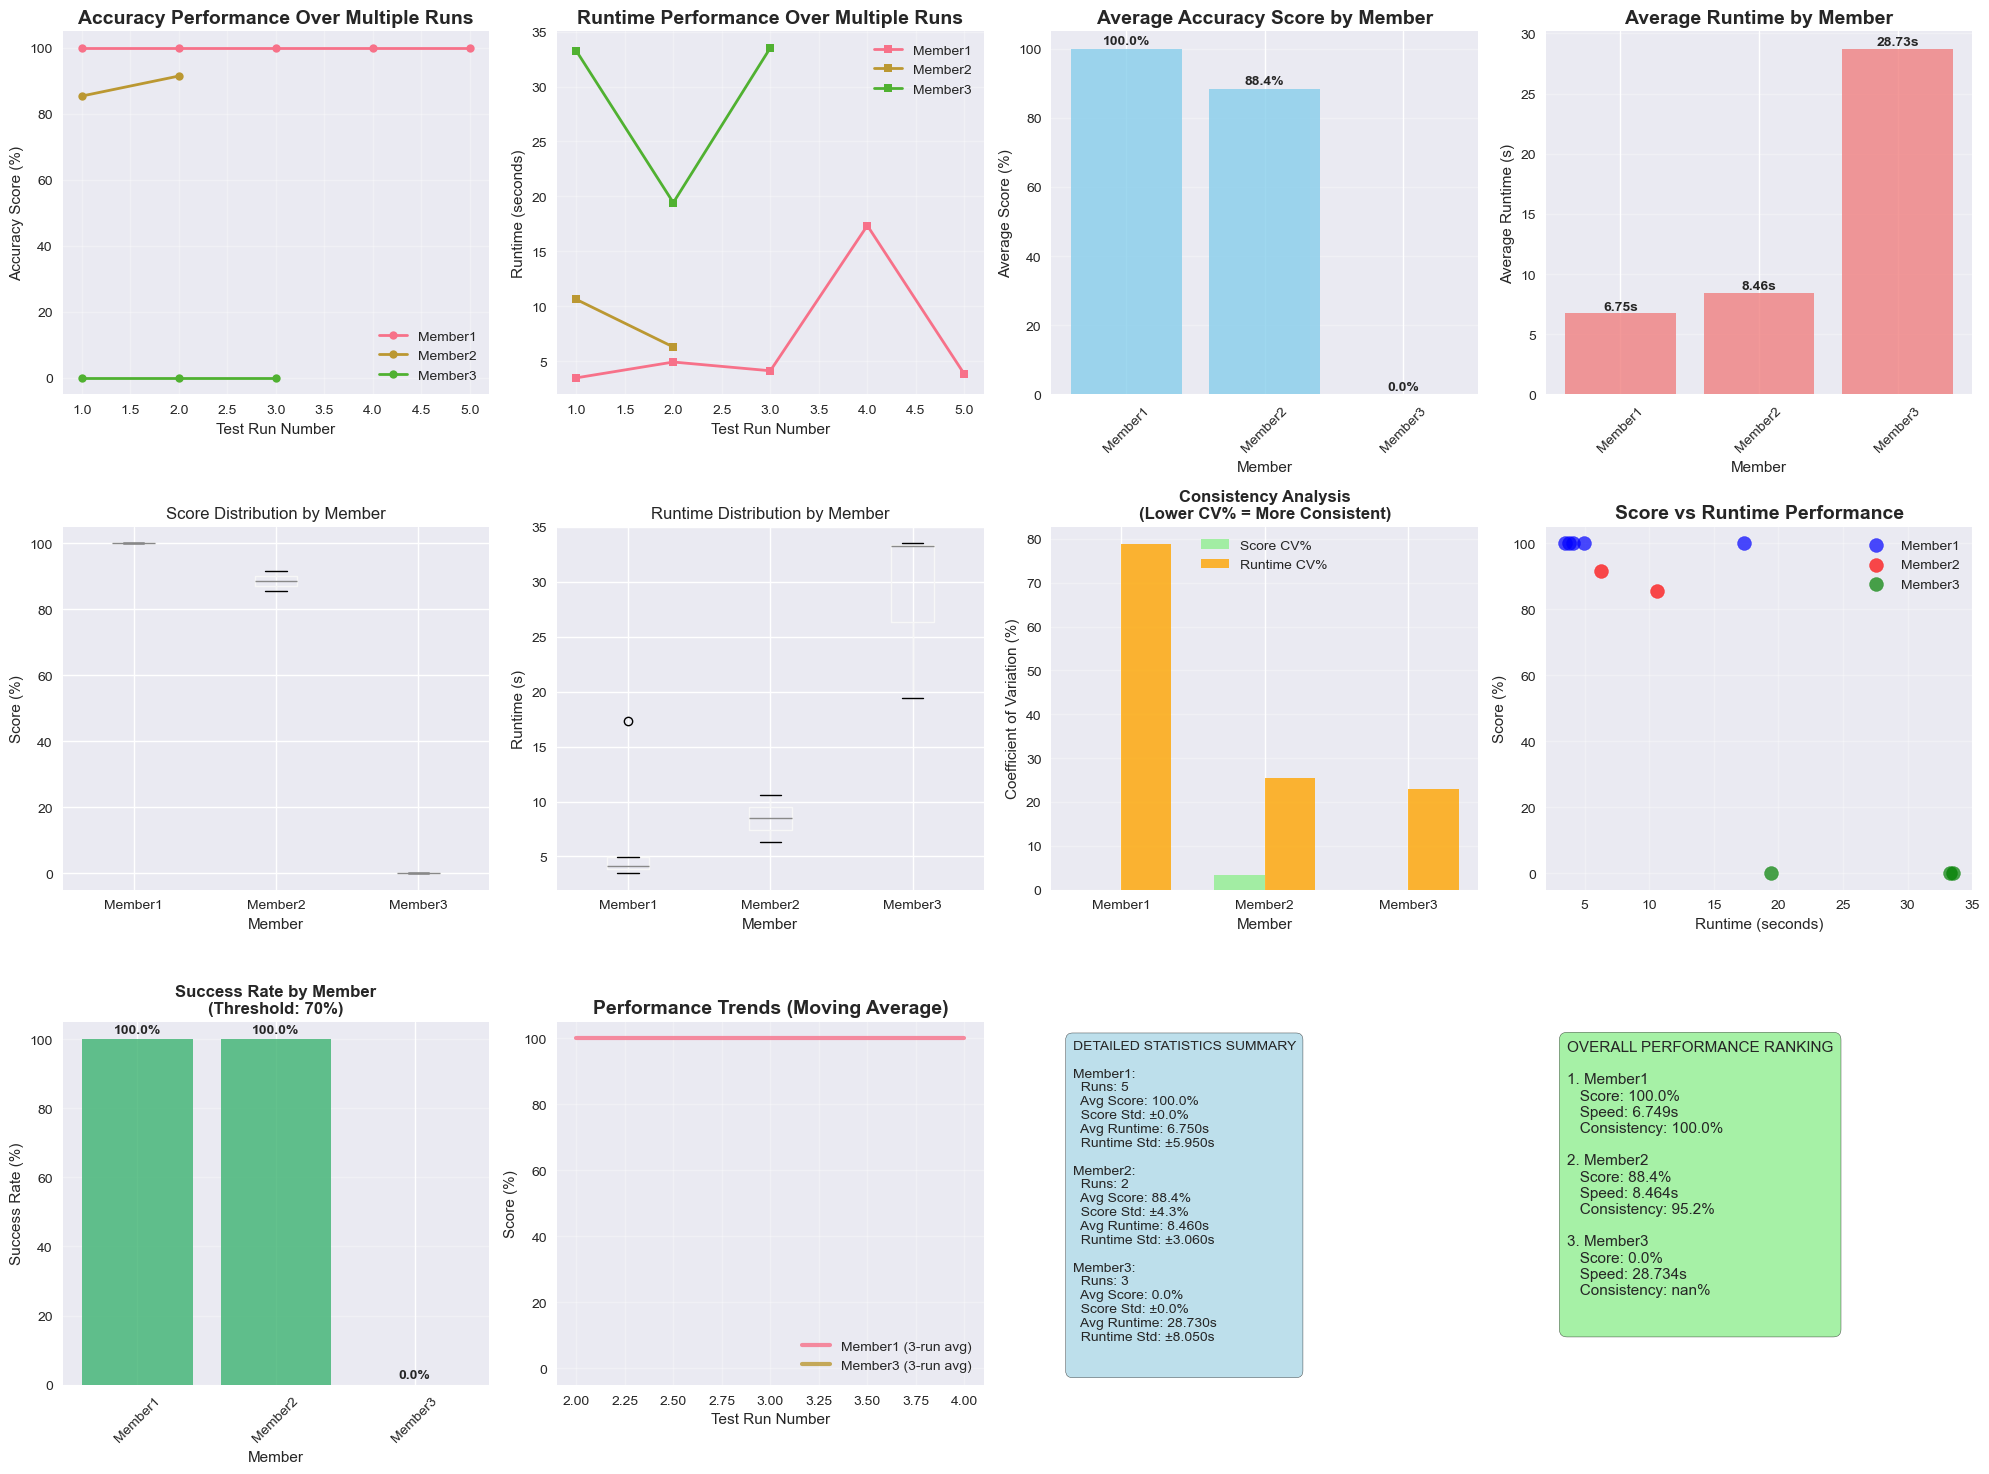

COMPREHENSIVE STATISTICAL ANALYSIS

OVERALL DATASET:
Total Test Runs: 10
Number of Members: 3
Number of Students Tested: 2
Data Collection Period: 2025-08-30 00:15:02.939019 to 2025-08-30 00:39:34.988230

MEMBER1 DETAILED ANALYSIS:
--------------------------------------------------
Test Runs Completed: 5

ACCURACY METRICS:
  Mean Score: 100.00%
  Median Score: 100.00%
  Standard Deviation: ±0.00%
  Min Score: 100.00%
  Max Score: 100.00%
  95th Percentile: 100.00%

RUNTIME METRICS:
  Mean Runtime: 6.749s
  Median Runtime: 4.137s
  Standard Deviation: ±5.950s
  Min Runtime: 3.492s
  Max Runtime: 17.350s

CONSISTENCY METRICS:
  Score Consistency (CV): 0.0% (High consistency)
  Runtime Consistency (CV): 88.2% (Low consistency)
  Success Rate (≥70%): 100.0%

MEMBER2 DETAILED ANALYSIS:
--------------------------------------------------
Test Runs Completed: 2

ACCURACY METRICS:
  Mean Score: 88.43%
  Median Score: 88.43%
  Standard Deviation: ±4.29%
  Min Score: 85.40%
  Max Score: 91.46%
  

C:\Users\Yung\AppData\Local\Temp\ipykernel_8044\1056229724.py:324: RuntimeWarning: invalid value encountered in scalar divide
  score_cv = (member_data['score_percentage'].std() / member_data['score_percentage'].mean()) * 100
c:\Users\Yung\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import numpy as np
from pathlib import Path
from datetime import datetime


class ComprehensiveResultsAnalyzer:
    """
    Advanced analyzer for multi-member verification system results.
    """
    
    def __init__(self, results_directory: str = "results"):
        self.results_dir = Path(results_directory)
        self.results_file = self.results_dir / "all_results.json"
        
    def load_results_dataframe(self) -> pd.DataFrame:
        """Load all results into a comprehensive DataFrame"""
        if not self.results_file.exists():
            print("No results file found!")
            return pd.DataFrame()
        
        try:
            with open(self.results_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            if not data:
                print("No data found in results file!")
                return pd.DataFrame()
            
            df = pd.DataFrame(data)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df['score_percentage'] = df['score'] * 100
            
            return df
        except Exception as e:
            print(f"Error loading results: {e}")
            return pd.DataFrame()
    
    def generate_comprehensive_analysis(self, save_plots: bool = True):
        """
        Generate comprehensive analysis with multiple visualizations.
        """
        df = self.load_results_dataframe()
        
        if df.empty:
            print("No data available for analysis!")
            return
        
        # Set plotting style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
        # Create comprehensive figure
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Performance Over Time (Line Plot)
        plt.subplot(3, 4, 1)
        for member in df['member'].unique():
            member_data = df[df['member'] == member].sort_values('timestamp')
            plt.plot(member_data['test_run'], member_data['score_percentage'], 
                    marker='o', linewidth=2, label=member, markersize=6)
        
        plt.title('Accuracy Performance Over Multiple Runs', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Accuracy Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 2. Runtime Performance Over Time
        plt.subplot(3, 4, 2)
        for member in df['member'].unique():
            member_data = df[df['member'] == member].sort_values('timestamp')
            plt.plot(member_data['test_run'], member_data['runtime'], 
                    marker='s', linewidth=2, label=member, markersize=6)
        
        plt.title('Runtime Performance Over Multiple Runs', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Runtime (seconds)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 3. Average Performance Comparison (Bar Chart)
        plt.subplot(3, 4, 3)
        avg_stats = df.groupby('member').agg({
            'score_percentage': 'mean',
            'runtime': 'mean'
        }).round(2)
        
        x_pos = np.arange(len(avg_stats))
        bars = plt.bar(x_pos, avg_stats['score_percentage'], alpha=0.8, color='skyblue')
        plt.title('Average Accuracy Score by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Score (%)')
        plt.xticks(x_pos, avg_stats.index, rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, avg_stats['score_percentage']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 4. Average Runtime Comparison
        plt.subplot(3, 4, 4)
        bars = plt.bar(x_pos, avg_stats['runtime'], alpha=0.8, color='lightcoral')
        plt.title('Average Runtime by Member', fontsize=14, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Average Runtime (s)')
        plt.xticks(x_pos, avg_stats.index, rotation=45)
        
        for bar, value in zip(bars, avg_stats['runtime']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.2f}s', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 5. Score Distribution (Box Plot)
        plt.subplot(3, 4, 5)
        df.boxplot(column='score_percentage', by='member', ax=plt.gca())
        plt.title('Score Distribution by Member')
        plt.xlabel('Member')
        plt.ylabel('Score (%)')
        plt.suptitle('')  # Remove default title
        
        # 6. Runtime Distribution (Box Plot)
        plt.subplot(3, 4, 6)
        df.boxplot(column='runtime', by='member', ax=plt.gca())
        plt.title('Runtime Distribution by Member')
        plt.xlabel('Member')
        plt.ylabel('Runtime (s)')
        plt.suptitle('')
        
        # 7. Consistency Analysis (CV - Coefficient of Variation)
        plt.subplot(3, 4, 7)
        consistency_stats = df.groupby('member').agg({
            'score_percentage': lambda x: (np.std(x) / np.mean(x)) * 100,
            'runtime': lambda x: (np.std(x) / np.mean(x)) * 100
        })
        
        x_pos = np.arange(len(consistency_stats))
        width = 0.35
        plt.bar(x_pos - width/2, consistency_stats['score_percentage'], width, 
               label='Score CV%', alpha=0.8, color='lightgreen')
        plt.bar(x_pos + width/2, consistency_stats['runtime'], width,
               label='Runtime CV%', alpha=0.8, color='orange')
        
        plt.title('Consistency Analysis\n(Lower CV% = More Consistent)', fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Coefficient of Variation (%)')
        plt.xticks(x_pos, consistency_stats.index)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # 8. Performance Efficiency Scatter
        plt.subplot(3, 4, 8)
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for i, member in enumerate(df['member'].unique()):
            member_data = df[df['member'] == member]
            plt.scatter(member_data['runtime'], member_data['score_percentage'],
                       label=member, alpha=0.7, s=100, color=colors[i % len(colors)])
        
        plt.title('Score vs Runtime Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Runtime (seconds)')
        plt.ylabel('Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 9. Success Rate Analysis (if you have pass/fail threshold)
        plt.subplot(3, 4, 9)
        success_threshold = 70  # 70% threshold for success
        success_stats = df.groupby('member').apply(
            lambda x: (x['score_percentage'] >= success_threshold).sum() / len(x) * 100
        ).reset_index(name='success_rate')
        
        bars = plt.bar(success_stats['member'], success_stats['success_rate'], 
                      alpha=0.8, color='mediumseagreen')
        plt.title(f'Success Rate by Member\n(Threshold: {success_threshold}%)', 
                 fontsize=12, fontweight='bold')
        plt.xlabel('Member')
        plt.ylabel('Success Rate (%)')
        plt.xticks(rotation=45)
        
        for bar, rate in zip(bars, success_stats['success_rate']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # 10. Performance Trends
        plt.subplot(3, 4, 10)
        for member in df['member'].unique():
            member_data = df[df['member'] == member].sort_values('timestamp')
            if len(member_data) > 1:
                # Calculate moving average if enough data points
                if len(member_data) >= 3:
                    member_data['score_ma'] = member_data['score_percentage'].rolling(window=3, center=True).mean()
                    plt.plot(member_data['test_run'], member_data['score_ma'], 
                            linewidth=3, label=f'{member} (3-run avg)', alpha=0.8)
        
        plt.title('Performance Trends (Moving Average)', fontsize=14, fontweight='bold')
        plt.xlabel('Test Run Number')
        plt.ylabel('Score (%)')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # 11. Detailed Statistics Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        
        stats_summary = df.groupby('member').agg({
            'score_percentage': ['mean', 'std', 'min', 'max'],
            'runtime': ['mean', 'std', 'min', 'max'],
            'test_run': 'count'
        }).round(2)
        
        # Flatten column names
        stats_summary.columns = ['_'.join(col) for col in stats_summary.columns]
        
        # Create table text
        table_text = "DETAILED STATISTICS SUMMARY\n\n"
        for member in stats_summary.index:
            table_text += f"{member}:\n"
            table_text += f"  Runs: {stats_summary.loc[member, 'test_run_count']}\n"
            table_text += f"  Avg Score: {stats_summary.loc[member, 'score_percentage_mean']:.1f}%\n"
            table_text += f"  Score Std: ±{stats_summary.loc[member, 'score_percentage_std']:.1f}%\n"
            table_text += f"  Avg Runtime: {stats_summary.loc[member, 'runtime_mean']:.3f}s\n"
            table_text += f"  Runtime Std: ±{stats_summary.loc[member, 'runtime_std']:.3f}s\n\n"
        
        plt.text(0.05, 0.95, table_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        
        # 12. Overall Ranking
        plt.subplot(3, 4, 12)
        plt.axis('off')
        
        # Calculate overall performance metric
        member_performance = []
        for member in df['member'].unique():
            member_data = df[df['member'] == member]
            avg_score = member_data['score_percentage'].mean()
            avg_runtime = member_data['runtime'].mean()
            consistency_score = 100 - ((member_data['score_percentage'].std() / avg_score) * 100)
            
            # Composite performance score (you can adjust weights)
            performance_score = (avg_score * 0.5) + ((1/avg_runtime) * 20 * 0.3) + (consistency_score * 0.2)
            
            member_performance.append({
                'member': member,
                'performance_score': performance_score,
                'avg_score': avg_score,
                'avg_runtime': avg_runtime,
                'consistency': consistency_score
            })
        
        # Sort by performance score
        member_performance.sort(key=lambda x: x['performance_score'], reverse=True)
        
        ranking_text = "OVERALL PERFORMANCE RANKING\n\n"
        for i, perf in enumerate(member_performance, 1):
            ranking_text += f"{i}. {perf['member']}\n"
            ranking_text += f"   Score: {perf['avg_score']:.1f}%\n"
            ranking_text += f"   Speed: {perf['avg_runtime']:.3f}s\n"
            ranking_text += f"   Consistency: {perf['consistency']:.1f}%\n\n"
        
        plt.text(0.05, 0.95, ranking_text, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
        
        plt.tight_layout()
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'comprehensive_analysis_{timestamp}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Analysis saved as '{filename}'")
        
        plt.show()
        
        return df
    
    def print_statistical_analysis(self):
        """Print detailed statistical analysis"""
        df = self.load_results_dataframe()
        
        if df.empty:
            return
        
        print("=" * 80)
        print("COMPREHENSIVE STATISTICAL ANALYSIS")
        print("=" * 80)
        
        # Overall statistics
        print(f"\nOVERALL DATASET:")
        print(f"Total Test Runs: {len(df)}")
        print(f"Number of Members: {df['member'].nunique()}")
        print(f"Number of Students Tested: {df['student_id'].nunique()}")
        print(f"Data Collection Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
        # Member-wise detailed analysis
        for member in sorted(df['member'].unique()):
            member_data = df[df['member'] == member]
            
            print(f"\n{member.upper()} DETAILED ANALYSIS:")
            print("-" * 50)
            print(f"Test Runs Completed: {len(member_data)}")
            
            # Accuracy Statistics
            print(f"\nACCURACY METRICS:")
            print(f"  Mean Score: {member_data['score_percentage'].mean():.2f}%")
            print(f"  Median Score: {member_data['score_percentage'].median():.2f}%")
            print(f"  Standard Deviation: ±{member_data['score_percentage'].std():.2f}%")
            print(f"  Min Score: {member_data['score_percentage'].min():.2f}%")
            print(f"  Max Score: {member_data['score_percentage'].max():.2f}%")
            print(f"  95th Percentile: {member_data['score_percentage'].quantile(0.95):.2f}%")
            
            # Runtime Statistics  
            print(f"\nRUNTIME METRICS:")
            print(f"  Mean Runtime: {member_data['runtime'].mean():.3f}s")
            print(f"  Median Runtime: {member_data['runtime'].median():.3f}s")
            print(f"  Standard Deviation: ±{member_data['runtime'].std():.3f}s")
            print(f"  Min Runtime: {member_data['runtime'].min():.3f}s")
            print(f"  Max Runtime: {member_data['runtime'].max():.3f}s")
            
            # Consistency Analysis
            score_cv = (member_data['score_percentage'].std() / member_data['score_percentage'].mean()) * 100
            runtime_cv = (member_data['runtime'].std() / member_data['runtime'].mean()) * 100
            print(f"\nCONSISTENCY METRICS:")
            print(f"  Score Consistency (CV): {score_cv:.1f}% ({'High' if score_cv < 10 else 'Moderate' if score_cv < 20 else 'Low'} consistency)")
            print(f"  Runtime Consistency (CV): {runtime_cv:.1f}% ({'High' if runtime_cv < 15 else 'Moderate' if runtime_cv < 30 else 'Low'} consistency)")
            
            # Success Rate (assuming 70% threshold)
            success_rate = (member_data['score_percentage'] >= 70).mean() * 100
            print(f"  Success Rate (≥70%): {success_rate:.1f}%")
        
        # Comparative Analysis
        print(f"\n{'='*80}")
        print("COMPARATIVE ANALYSIS")
        print("=" * 80)
        
        # Best performer in each category
        best_accuracy = df.loc[df['score_percentage'].idxmax()]
        fastest_runtime = df.loc[df['runtime'].idxmin()]
        
        print(f"\nBEST SINGLE PERFORMANCE:")
        print(f"  Highest Score: {best_accuracy['member']} - {best_accuracy['score_percentage']:.2f}% (Run #{best_accuracy['test_run']})")
        print(f"  Fastest Runtime: {fastest_runtime['member']} - {fastest_runtime['runtime']:.3f}s (Run #{fastest_runtime['test_run']})")
        
        # Average performance leaders
        avg_performance = df.groupby('member').agg({
            'score_percentage': 'mean',
            'runtime': 'mean'
        })
        
        best_avg_accuracy = avg_performance['score_percentage'].idxmax()
        best_avg_speed = avg_performance['runtime'].idxmin()
        
        print(f"\nAVERAGE PERFORMANCE LEADERS:")
        print(f"  Best Average Accuracy: {best_avg_accuracy} - {avg_performance.loc[best_avg_accuracy, 'score_percentage']:.2f}%")
        print(f"  Best Average Speed: {best_avg_speed} - {avg_performance.loc[best_avg_speed, 'runtime']:.3f}s")
        
        # Statistical significance testing (if multiple runs per member)
        print(f"\nSTATISTICAL INSIGHTS:")
        if len(df['member'].unique()) >= 2:
            from scipy import stats
            
            members = list(df['member'].unique())
            if len(members) >= 2:
                member1_scores = df[df['member'] == members[0]]['score_percentage']
                member2_scores = df[df['member'] == members[1]]['score_percentage']
                
                if len(member1_scores) > 1 and len(member2_scores) > 1:
                    t_stat, p_value = stats.ttest_ind(member1_scores, member2_scores)
                    print(f"  T-test between {members[0]} and {members[1]}:")
                    print(f"    T-statistic: {t_stat:.3f}")
                    print(f"    P-value: {p_value:.3f}")
                    print(f"    Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

# Example usage and integration with your existing system
def run_comprehensive_analysis():
    """
    Run the comprehensive analysis on existing results.
    """
    analyzer = ComprehensiveResultsAnalyzer()
    
    # Generate all visualizations
    df = analyzer.generate_comprehensive_analysis()
    
    # Print detailed statistics
    analyzer.print_statistical_analysis()
    
    return df

# Initialize the enhanced system
enhanced_logger = ComprehensiveResultsAnalyzer()
print("Enhanced ResultLogger initialized - now accumulates all results")

if __name__ == "__main__":
    df = run_comprehensive_analysis()